# Things to install

## Colab

In [ ]:
!apt update && apt install -y openslide-tools
!pip install openslide-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Locale

In [11]:
!pip install openslide-python
!pip install opencv-python

In [1]:
# The path can also be read from a config file, etc.
OPENSLIDE_PATH = r'C:\Users\sofia\openslide-win64-20230414\openslide-win64-20230414\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

# Code

## Imports and env var

In [2]:
import openslide
import cv2
from matplotlib import pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import tensorflow as tf

path_to_image = "../slides/RECHERCHE-010.svs"
path_to_xml = "../annotations/RECHERCHE-010.xml"
output_width = 2000
output_height = 2000

## Functions

In [3]:
def get_annotatios(file_path):
    # Parsa il file XML delle annotazioni
    tree = ET.parse(file_path)
    root = tree.getroot()
    # Ottieni tutte le annotazioni dal file XML
    annotations = []
    for annotation in root.iter('Annotation'):
        name = annotation.get('Name')
        coordinates = []
        for coordinate in annotation.iter('Coordinate'):
            x = float(coordinate.get('X'))
            y = float(coordinate.get('Y'))
            coordinates.append((x, y))
        annotations.append({'name': name, 'coordinates': coordinates})
    return annotations


In [4]:
def is_mostly_white(image, threshold_w=0.85, threshold_p = 0.98):
    # Converti l'immagine in scala di grigi
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calcola la soglia per considerare i pixel bianchi
    pixel_threshold = int(threshold_w * 255)

    # Conta i pixel bianchi nell'immagine
    white_pixels = np.sum(gray_image >= pixel_threshold)

    # Calcola la percentuale di pixel bianchi rispetto alla dimensione totale dell'immagine
    white_percentage = white_pixels / (gray_image.shape[0] * gray_image.shape[1])

    # Verifica se la percentuale di pixel bianchi supera la soglia
    if white_percentage >= threshold_p:
        return True, white_percentage
    else:
        return False, white_percentage

In [5]:
def get_labels(labels, annotations):
    for annotation in annotations:
        polygon = np.array([annotation['coordinates']], dtype=np.int32)
        cv2.fillPoly(labels, polygon, 1)

In [6]:
def plt_image(image, labes):
    fig, axs = plt.subplots(1, 2)
    # Primo subplot: labels
    axs[0].imshow(labes)
    axs[0].axis('off')
    # Secondo subplot: immagine
    axs[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[1].axis('off')
    # Mostra i subplot affiancati
    plt.show()

In [7]:
def data_augment(image):
    image_90 = np.rot90(image)
    image_180 = np.rot90(image_90)
    image_270 = np.rot90(image_180)
    return image_90, image_180, image_270

## 'Main'

In [42]:
# Carica l'immagine svs
wsi = openslide.OpenSlide(path_to_image)
# Ottieni le dimensioni dell'immagine
w, h = wsi.dimensions
# Calcola il numero di righe e colonne necessarie per suddividere l'immagine
num_rows = h // output_height
num_cols = w // output_width

In [43]:
print(num_rows, num_cols)

37 88


In [44]:
annotations = get_annotatios(path_to_xml)
# Crea un'immagine di output con le stesse dimensioni dell'immagine svs
label_image = np.zeros((h, w), dtype=np.uint8)
get_labels(label_image, annotations)

In [57]:
dataset = []
labels = []

#for row in range(num_rows):
#    for col in range(num_cols):
for row in range(3, 5):
    for col in range(58, 60):
        # Calcola le coordinate di inizio e fine per l'immagine corrente
        x = col * output_width
        y = row * output_height
        x_end = x + output_width
        y_end = y + output_height
        
        # Estrai l'immagine corrente
        region = wsi.read_region((x, y), 0, (output_width, output_height))
        image = cv2.cvtColor(np.array(region), cv2.COLOR_RGBA2BGR)
        
        is_white, p = is_mostly_white(image)
        if not is_white:
            if not ((col == num_cols-1) or (row == num_rows-1)):
                x_h = x + output_width // 2 
                x_v = x
                x_d = x + output_width // 2 
                y_h = y
                y_v = y + output_height // 2
                y_d = y + output_width // 2 
                region_h = wsi.read_region((x_h, y_h), 0, (output_width, output_height))
                region_v = wsi.read_region((x_v, y_v), 0, (output_width, output_height))
                region_d = wsi.read_region((x_d, y_d), 0, (output_width, output_height))
                image_h = cv2.cvtColor(np.array(region_h), cv2.COLOR_RGBA2BGR)
                image_v = cv2.cvtColor(np.array(region_v), cv2.COLOR_RGBA2BGR)
                image_d = cv2.cvtColor(np.array(region_d), cv2.COLOR_RGBA2BGR)
                is_white_h, _ = is_mostly_white(image_h)
                is_white_v, _ = is_mostly_white(image_v)
                is_white_d, _ = is_mostly_white(image_d)
                if not is_white_h:
                    dataset.append(image_h)
                    labels.append(label_image[y_h: y_h+output_height, x_h: x_h+output_width])
                if not is_white_v:
                    dataset.append(image_v)
                    labels.append(label_image[y_v: y_v+output_height, x_v: x_v+output_width])
                if not is_white_d:
                    dataset.append(image_d)
                    labels.append(label_image[y_d: y_d+output_height, x_d: x_d+output_width])
            dataset.append(image)
            labels.append(label_image[y:y_end, x: x_end])
dataset = np.array(dataset)
labels = np.array(labels)

In [58]:
dataset.shape

(16, 2000, 2000, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


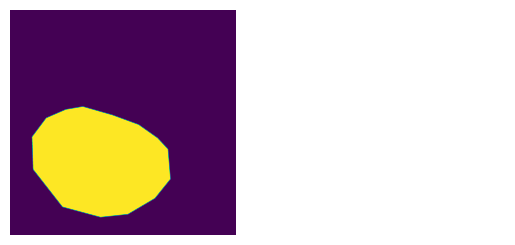

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


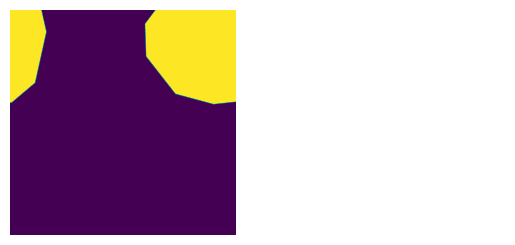

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


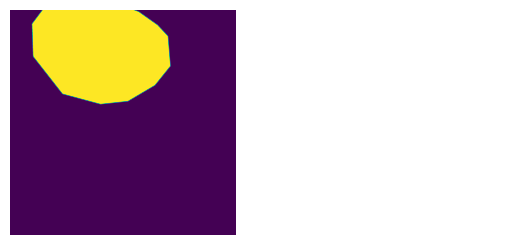

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


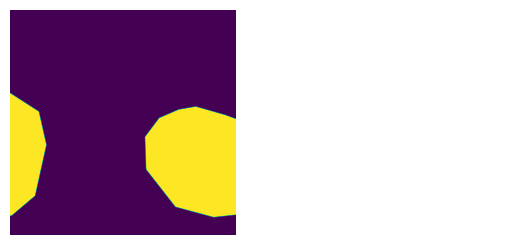

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


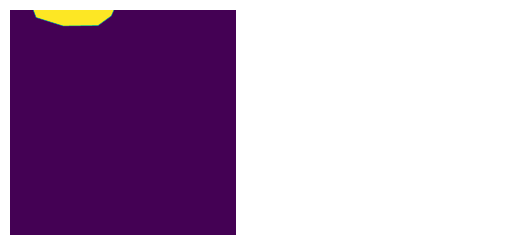

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


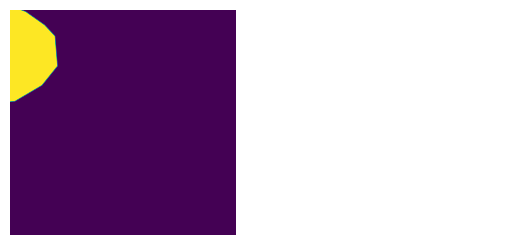

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


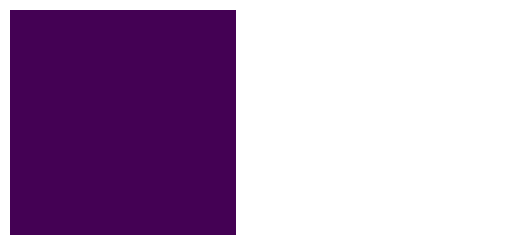

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


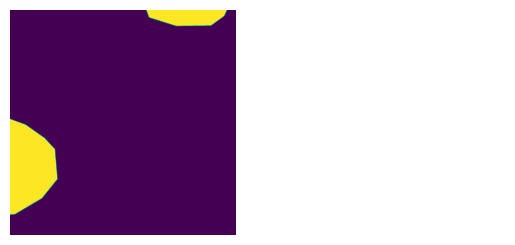

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


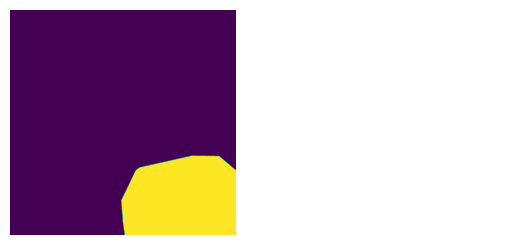

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


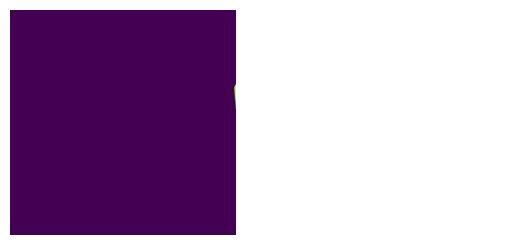

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


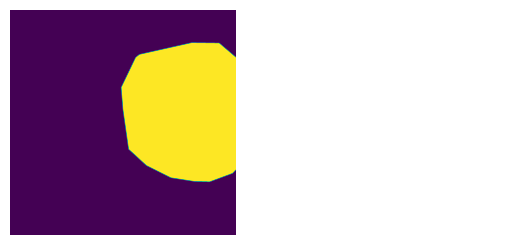

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


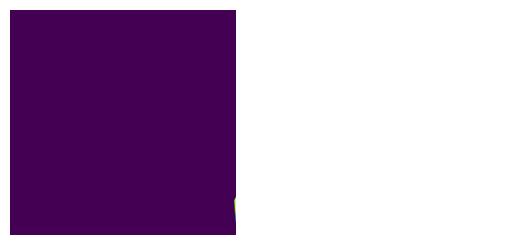

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


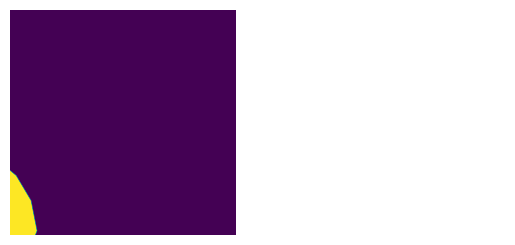

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


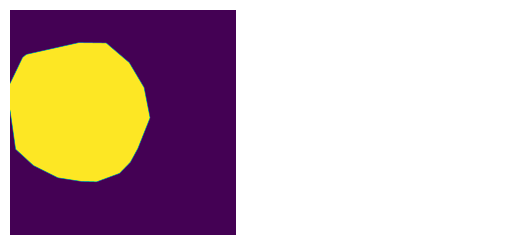

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


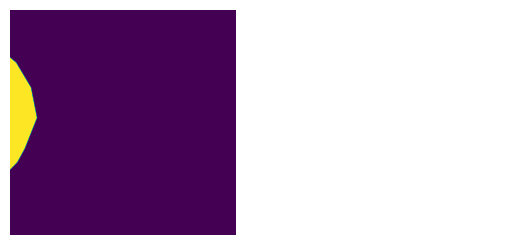

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


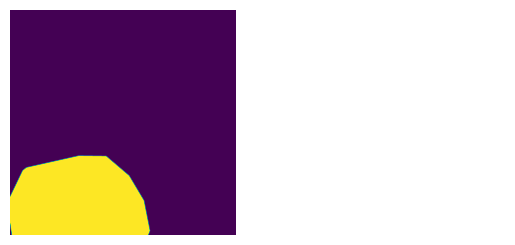

IndexError: index 16 is out of bounds for axis 0 with size 16

In [61]:
for i in range(len(dataset)):
  plt_image(dataset[i], labels[i])

In [14]:
np.save('dataset.npy', dataset)

In [3]:
data = np.load('dataset.npy')
data.shape

In [24]:
model = tf.keras.Sequential([
  tf.keras.layers.Resizing(output_width//2, output_height//2), 
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.25),
])

In [56]:
resize = tf.keras.Sequential([
  tf.keras.layers.Resizing(output_width, output_height),
])

In [ ]:
for i in range(len(dataset)):
    image = dataset[i]
    #grayscaled = tf.image.rgb_to_grayscale(image)
    #print(grayscaled.shape)
    saturated = tf.image.adjust_saturation(image, 3)
    print(saturated.shape)
    bright = tf.image.adjust_brightness(image, 0.4)
    print(bright.shape)
    cropped = tf.image.central_crop(image, central_fraction=0.5)
    cropped = resize(cropped)
    print(cropped.shape)
    dataset=np.append(dataset, [saturated, bright, cropped], axis=0)

In [ ]:
for i in range(len(dataset)):
    # Primo subplot: labels
    # Secondo subplot: immagine
    plt.imshow(cv2.cvtColor(dataset[i], cv2.COLOR_BGR2RGB))
    # Mostra i subplot affiancati
    plt.show()

# TODO
* Non stampa le immagini perchè sono float e vuole int
* Controllare con un'immagine di esempio i risultati delle modifiche
* 